<a href="https://colab.research.google.com/github/KetakiN/20-21/blob/main/NYSDOH_data_wrangling_pre_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from google.colab import files

In [ ]:
df=pd.read_csv('/content/sample_data/NYSDOH_clean2.csv')

In [ ]:
df=df.drop(['Unnamed:_0','Unnamed: 0'],axis=1)

In [ ]:
df.columns

Index(['Hospital_Service_Area', 'Hospital_County',
       'Operating_Certificate_Number', 'Permanent_Facility_Id',
       'Facility_Name', 'Age_Group', 'Zip_Code__3_digits', 'Gender', 'Race',
       'Length_of_Stay', 'Type_of_Admission', 'Patient_Disposition',
       'Discharge_Year', 'CCS_Diagnosis_Code', 'CCS_Diagnosis_Description',
       'CCS_Procedure_Code', 'CCS_Procedure_Description', 'APR_DRG_Code',
       'APR_DRG_Description', 'APR_MDC_Code', 'APR_MDC_Description',
       'APR_Severity_of_Illness_Code', 'APR_Severity_of_Illness_Description',
       'APR_Risk_of_Mortality', 'APR_Medical_Surgical_Description',
       'Payment_Typology_1', 'Payment_Typology_2', 'Payment_Typology_3',
       'Birth_Weight', 'Abortion_Edit_Indicator',
       'Emergency_Department_Indicator', 'Total_Charges', 'Total_Costs',
       'Ratio_of_Total_Costs_to_Total_Charges', 'Length_groups'],
      dtype='object')

In [ ]:
df.shape

(118049, 35)

In [ ]:
# Drop columns that will not be relevant to predicting length of stay, will be repetitive of information in other columns,codes or status determined at discharge or toward discharge
df=df.drop(['Operating_Certificate_Number', 'Permanent_Facility_Id','Patient_Disposition',
       'Discharge_Year','APR_DRG_Code',
       'APR_DRG_Description', 'APR_MDC_Code', 'APR_MDC_Description',
       'APR_Severity_of_Illness_Code', 'APR_Severity_of_Illness_Description',
       'APR_Risk_of_Mortality', 'APR_Medical_Surgical_Description','Payment_Typology_2', 'Payment_Typology_3',
       'Birth_Weight', 'Abortion_Edit_Indicator','Total_Charges', 'Total_Costs',
       'Ratio_of_Total_Costs_to_Total_Charges'],axis=1)

In [ ]:
df.columns

Index(['Hospital_Service_Area', 'Hospital_County', 'Facility_Name',
       'Age_Group', 'Zip_Code__3_digits', 'Gender', 'Race', 'Length_of_Stay',
       'Type_of_Admission', 'CCS_Diagnosis_Code', 'CCS_Diagnosis_Description',
       'CCS_Procedure_Code', 'CCS_Procedure_Description', 'Payment_Typology_1',
       'Emergency_Department_Indicator', 'Length_groups'],
      dtype='object')

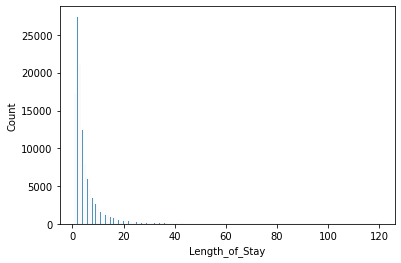

In [ ]:
sns.histplot(x=df['Length_of_Stay'],data=df)
plt.show()

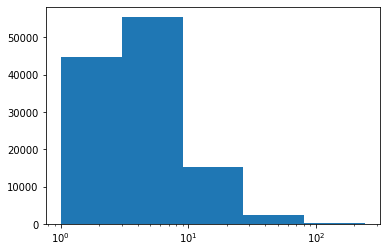

In [ ]:
bins = 3**(np.arange(0,6))

data=df['Length_of_Stay']
plt.hist(data,bins=bins) 
plt.xscale('log')

In [ ]:
df.Length_of_Stay.describe()

count    118049.000000
mean          5.503537
std           8.104633
min           1.000000
25%           2.000000
50%           3.000000
75%           6.000000
max         120.000000
Name: Length_of_Stay, dtype: float64

In [ ]:
df.shape

(118049, 16)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


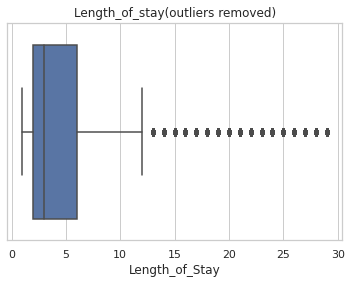

In [ ]:
#Check with 5% outliers removed
sns.set_theme(style="whitegrid")
std=df['Length_of_Stay'].std()
mean=df['Length_of_Stay'].mean()
cutoff=std*3
lower,upper=mean-cutoff,mean+cutoff
trimmed_df=df[(df['Length_of_Stay']>lower)&(df['Length_of_Stay']<upper)]
sns.boxplot(trimmed_df['Length_of_Stay'])
plt.title('Length_of_stay(outliers removed)')
#plt.savefig('box_length.png')

plt.show()

In [ ]:
trimmed_df.Length_of_Stay.describe()

count    116066.000000
mean          4.733531
std           4.637916
min           1.000000
25%           2.000000
50%           3.000000
75%           6.000000
max          29.000000
Name: Length_of_Stay, dtype: float64

In [ ]:
# Create length of stay bins, For 1 day: 24 hour stay, 2-5 days(below mean),
# 6-20 days(above mean to 20),21 to 90 days(short term rehab hospital stay common durations) 
# and 90+ days(long term faciltities). The upper limits of the ranges were used
bins=[-np.inf,1,5,20,90,np.inf]
#bin labels
labels=['0-1','2-5','6-20','21-90','91-120']
df['length_groups']=pd.cut(df['Length_of_Stay'],bins,labels=labels)

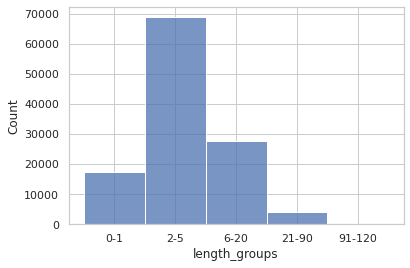

In [ ]:
sns.histplot(x=df['length_groups'])
plt.show()

In [ ]:
df.length_groups.unique()

['2-5', '6-20', '0-1', '21-90', '91-120']
Categories (5, object): ['0-1' < '2-5' < '6-20' < '21-90' < '91-120']

In [ ]:
# remap age groups
df.Age_Group.unique()

array(['30 to 49', '18 to 29', '0 to 17', '70 or Older', '50 to 69'],
      dtype=object)

In [ ]:
dict={'70 or Older':80, '50 to 69':60,'30 to 49':40 , '18 to 29':20, '0 to 17':10}

In [ ]:
df=df.replace({'Age_Group':dict})

In [ ]:
df.Age_Group.unique()

array([40, 20, 10, 80, 60])

In [ ]:
df[df['CCS_Procedure_Code']!=0].value_counts().sum()

89655

In [ ]:
# There are 258 different types of diagnosis categories.Lets take a look at the top 17 most occurring
common_diag=df[df.groupby('CCS_Diagnosis_Description')['CCS_Diagnosis_Description'].transform('size') >1700]

common_diag['CCS_Diagnosis_Description'].unique()

array(['Osteoarthritis', 'Liveborn',
       'Complication of device; implant or graft', 'Cardiac dysrhythmias',
       'Acute cerebrovascular disease',
       'Other complications of birth; puerperium affecting management of mother',
       'Pneumonia (except that caused by tuberculosis or sexually transmitted disease)',
       'Congestive heart failure; nonhypertensive',
       'Septicemia (except in labor)',
       'Diabetes mellitus with complications', 'Asthma',
       'Spondylosis; intervertebral disc disorders; other back problems',
       'Schizophrenia and other psychotic disorders',
       'Substance-related disorders', 'Mood disorders',
       'Skin and subcutaneous tissue infections',
       'Alcohol-related disorders'], dtype=object)

In [ ]:
common_diag['CCS_Diagnosis_Description'].unique().shape

(17,)

In [ ]:
common_diag['CCS_Diagnosis_Description'].describe()

count        48615
unique          17
top       Liveborn
freq         11554
Name: CCS_Diagnosis_Description, dtype: object

In [ ]:
#df=common_diag

In [ ]:
#remap common diagnosis names to abrreviated versions
dict={ 'Osteoarthritis':'OA', 'Liveborn':'LB',
       'Complication of device; implant or graft':'CM1', 'Cardiac dysrhythmias':'Cd',
       'Acute cerebrovascular disease':'CVA',
       'Other complications of birth; puerperium affecting management of mother':'CM2',
       'Pneumonia (except that caused by tuberculosis or sexually transmitted disease)':'PNU',
       'Congestive heart failure; nonhypertensive':'CHF',
       'Septicemia (except in labor)':'Sept',
       'Diabetes mellitus with complications':'DM', 'Asthma':'ASTH',
       'Spondylosis; intervertebral disc disorders; other back problems':'Spondy',
       'Schizophrenia and other psychotic disorders':'SCHIZ',
       'Substance-related disorders':'SubA', 'Mood disorders':'Mood',
       'Skin and subcutaneous tissue infections':'Skin',
       'Alcohol-related disorders':'Alch'}

In [ ]:
common_diag=common_diag.replace({'CCS_Diagnosis_Description':dict})


In [ ]:
common_diag['CCS_Diagnosis_Description'].unique()

array(['OA', 'LB', 'CM1', 'Cd', 'CVA', 'CM2', 'PNU', 'CHF', 'Sept', 'DM',
       'ASTH', 'Spondy', 'SCHIZ', 'SubA', 'Mood', 'Skin', 'Alch'],
      dtype=object)

In [ ]:
dfcommon=pd.DataFrame(common_diag['CCS_Diagnosis_Description'].value_counts())

In [ ]:
dfcommon.columns=['Count']

In [ ]:
dfcommon.reset_index(inplace=True)

In [ ]:
dfcommon.columns=['Diagnosis','Count']

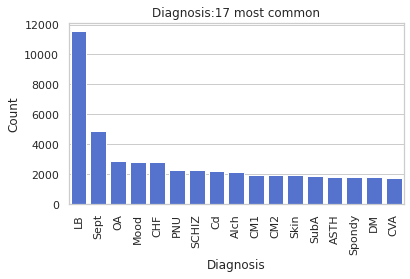

In [ ]:
ax=sns.barplot(x='Diagnosis',y='Count',data=dfcommon,color='royalblue')
plt.setp(ax.get_xticklabels(),rotation=90)
plt.xlabel('Diagnosis')
plt.ylabel('Count')
plt.title('Diagnosis:17 most common')
plt.gcf().subplots_adjust(bottom=0.25)
#plt.savefig('baro_diag.png')
plt.show()
#files.download('baro_diag.png')


In [ ]:
dfdiag=common_diag.groupby('CCS_Diagnosis_Description')['Length_of_Stay'].mean().reset_index()
dfdiag=dfdiag.sort_values('Length_of_Stay',ascending=False)
dfdiag.head()

,CCS_Diagnosis_Description,Length_of_Stay
12,SCHIZ,16.969577
9,Mood,10.370956
13,Sept,9.590272
5,CVA,7.624357
3,CM1,7.169666


In [ ]:
dfdiag.CCS_Diagnosis_Description.unique()

array(['SCHIZ', 'Mood', 'Sept', 'CVA', 'CM1', 'SubA', 'CHF', 'DM', 'Alch',
       'PNU', 'Skin', 'Cd', 'Spondy', 'LB', 'ASTH', 'CM2', 'OA'],
      dtype=object)

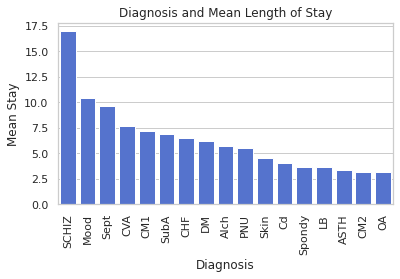

In [ ]:
ax=sns.barplot(x='CCS_Diagnosis_Description',y='Length_of_Stay',data=dfdiag,color='royalblue')
plt.setp(ax.get_xticklabels(),rotation=90)
plt.xlabel('Diagnosis')
plt.ylabel('Mean Stay')
plt.title('Diagnosis and Mean Length of Stay')
plt.gcf().subplots_adjust(bottom=0.25)
#plt.savefig('bar_diagnosis.png')
plt.show()
#files.download('bar_diagnosis.png')
    
  

In [ ]:
common_diag['CCS_Diagnosis_Description'].replace({'Spondy':'Spon'},inplace=True)

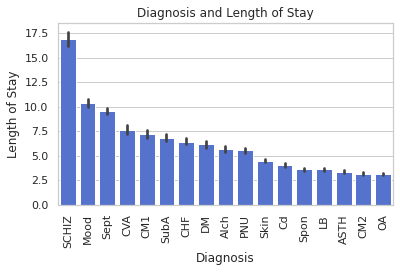

In [ ]:
list=['SCHIZ', 'Mood', 'Sept', 'CVA', 'CM1', 'SubA', 'CHF', 'DM', 'Alch',
       'PNU', 'Skin', 'Cd', 'Spon', 'LB', 'ASTH', 'CM2', 'OA']
dfdg=common_diag.sort_values('Length_of_Stay',ascending=False)
ax=sns.barplot(x='CCS_Diagnosis_Description',y='Length_of_Stay',data=dfdg, color='royalblue',order=list)
plt.xlabel('Diagnosis')
plt.ylabel('Length of Stay')
plt.title('Diagnosis and Length of Stay')
plt.gcf().subplots_adjust(bottom=0.25)
plt.setp(ax.get_xticklabels(),rotation=90)
#plt.savefig('ebar_diagnosis.png')
#files.download('ebar_diagnosis.png')
plt.show()

In [ ]:
df.CCS_Procedure_Description.describe()

count      118049
unique        226
top       NO PROC
freq        28394
Name: CCS_Procedure_Description, dtype: object

In [ ]:
df.Payment_Typology_1.unique()

array(['Medicare', 'Self-Pay', 'Medicaid', 'Blue Cross/Blue Shield',
       'Federal/State/Local/VA', 'Private Health Insurance',
       'Miscellaneous/Other', 'Department of Corrections',
       'Managed Care, Unspecified', 'Unknown'], dtype=object)

In [ ]:
# Abbreviate insurance names and remap
dict={'Medicare':'MCR', 'Medicaid':'MCD', 'Blue Cross/Blue Shield':'BCBS',
       'Private Health Insurance':'PHI', 'Self-Pay':'SP', 'Miscellaneous/Other':'Other',
       'Federal/State/Local/VA':'GovI', 'Department of Corrections':'DOC',
       'Managed Care, Unspecified':'MC', 'Unknown':'U'}

In [ ]:
df=df.replace({'Payment_Typology_1':dict})

In [ ]:
df.Payment_Typology_1.unique()

array(['MCR', 'SP', 'MCD', 'BCBS', 'GovI', 'PHI', 'Other', 'DOC', 'MC',
       'U'], dtype=object)

In [ ]:
dfp=df.groupby('Payment_Typology_1')['Length_of_Stay'].mean().reset_index()
dfp=dfp.sort_values('Length_of_Stay',ascending=False)
dfp.head()

,Payment_Typology_1,Length_of_Stay
1,DOC,9.307971
5,MCR,6.631370
9,U,6.626062
6,Other,5.680350
4,MCD,5.313581


In [ ]:
dfp.Payment_Typology_1.unique()

array(['DOC', 'MCR', 'U', 'Other', 'MCD', 'GovI', 'SP', 'PHI', 'MC',
       'BCBS'], dtype=object)

In [ ]:
list=['DOC', 'MCR','U','Other','MC','MCD', 'GovI', 'SP', 'PHI', 'BCBS']

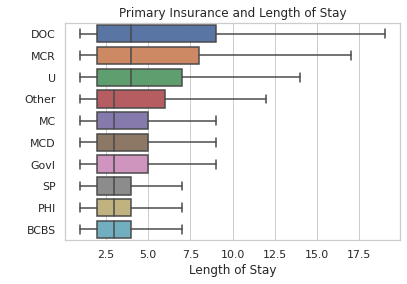

In [ ]:
sns.set_theme(style="whitegrid")
dfin=df.sort_values('Length_of_Stay',ascending=False)
sns.boxplot(y='Payment_Typology_1',x='Length_of_Stay',orient='h',data=dfin,showfliers=False,order=list)
plt.title('Primary Insurance and Length of Stay')
plt.xlabel('Length of Stay')
plt.ylabel(' ')
#plt.savefig('box_ins.png')
plt.show()
#files.download('box_ins.png')

In [ ]:
dict={'White':'W', 'Other Race':'OR', 'Black/African American':'AA', 'Multi-racial':'MR'}

In [ ]:
df=df.replace({'Race':dict})

In [ ]:
df.Race.unique()

array(['W', 'AA', 'OR', 'MR'], dtype=object)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

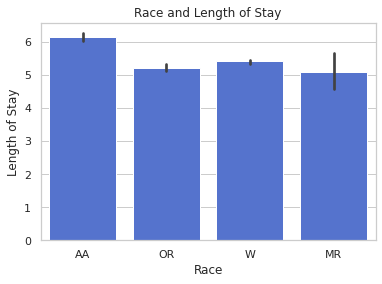

In [ ]:
list=['AA','OR','W','MR']
sns.barplot(x='Race',y='Length_of_Stay',data=df,order=list,color='royalblue')
plt.title('Race and Length of Stay')
plt.xlabel('Race')
plt.ylabel('Length of Stay')
plt.savefig('Racebar.png')
files.download('Racebar.png')

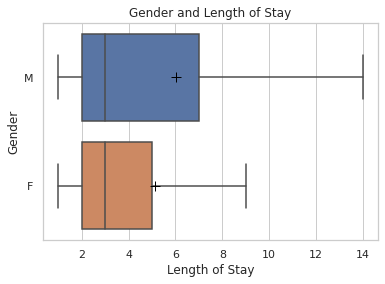

In [ ]:
dfgen=df.sort_values('Length_of_Stay',ascending=False)
sns.boxplot(x='Length_of_Stay',y='Gender',orient='h',showfliers=False,data=dfgen,order=['M','F'],showmeans=True,meanprops={"marker": "+", 
                       "markeredgecolor": "black", 
                       "markersize": "10"} )
plt.xlabel('Length of Stay')
plt.ylabel('Gender')
plt.title('Gender and Length of Stay')
#plt.savefig('box_gender.png')
plt.show()
#files.download('box_gender.png')

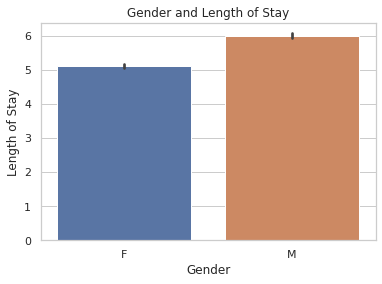

In [ ]:
sns.barplot(x='Gender',y='Length_of_Stay',data=df)
plt.xlabel('Gender')
plt.ylabel('Length of Stay')
plt.title('Gender and Length of Stay')
#plt.savefig('bar_gender.png')
plt.show()
#files.download('bar_gender.png')

In [ ]:
df.head()

,Hospital_Service_Area,Hospital_County,Facility_Name,Age_Group,Zip_Code__3_digits,Gender,Race,Length_of_Stay,Type_of_Admission,CCS_Diagnosis_Code,CCS_Diagnosis_Description,CCS_Procedure_Code,CCS_Procedure_Description,Payment_Typology_1,Emergency_Department_Indicator,Length_groups,length_groups
0,Western NY,Erie,Buffalo General Medical Center,40,142,F,W,3.0,Elective,203,Osteoarthritis,153,"HIP REPLACEMENT,TOT/PRT",MCR,N,below_mean,2-5
1,Western NY,Erie,Women And Children's Hospital Of Buffalo,20,OOS,F,AA,5.0,Urgent,183,Hypertension complicating pregnancy; childbirt...,134,CESAREAN SECTION,SP,N,below_mean,2-5
2,Western NY,Chautauqua,Brooks Memorial Hospital,10,140,M,W,3.0,Newborn,218,Liveborn,0,NO PROC,MCD,N,below_mean,2-5
3,Western NY,Cattaraugus,Olean General Hospital,40,147,F,W,6.0,Emergency,237,Complication of device; implant or graft,0,NO PROC,MCR,Y,above_mean,6-20
4,Western NY,Cattaraugus,Olean General Hospital,10,147,F,W,2.0,Newborn,218,Liveborn,228,PROPHYLACTIC VAC/INOCUL,BCBS,N,below_mean,2-5


In [ ]:
df.dtypes

Hospital_Service_Area               object
Hospital_County                     object
Facility_Name                       object
Age_Group                            int64
Zip_Code__3_digits                  object
Gender                              object
Race                                object
Length_of_Stay                     float64
Type_of_Admission                   object
CCS_Diagnosis_Code                   int64
CCS_Diagnosis_Description           object
CCS_Procedure_Code                   int64
CCS_Procedure_Description           object
Payment_Typology_1                  object
Emergency_Department_Indicator      object
Length_groups                       object
length_groups                     category
dtype: object

In [ ]:
df.rename(columns={'Length_groups': 'Below_Above_mean'}, inplace=True)

In [ ]:
df.CCS_Procedure_Code.unique().shape

(226,)

In [ ]:
df.CCS_Procedure_Description.unique().shape

(226,)

In [ ]:
# CCS procedure code provides same information as the description, drop codes
df=df.drop('CCS_Procedure_Code',axis=1)

In [ ]:
df.CCS_Diagnosis_Code.unique().shape

(257,)

In [ ]:
df.CCS_Diagnosis_Description.unique().shape

(257,)

In [ ]:
# drop CCS diagnosis Codes and keep description
df=df.drop('CCS_Diagnosis_Code',axis=1)

In [ ]:
df.Zip_Code__3_digits.unique().shape


(51,)

In [ ]:
df.columns

Index(['Hospital_Service_Area', 'Hospital_County', 'Facility_Name',
       'Age_Group', 'Zip_Code__3_digits', 'Gender', 'Race', 'Length_of_Stay',
       'Type_of_Admission', 'CCS_Diagnosis_Description',
       'CCS_Procedure_Description', 'Payment_Typology_1',
       'Emergency_Department_Indicator', 'Below_Above_mean', 'length_groups'],
      dtype='object')

In [ ]:
#create a column with mean length of stay for each diagnosis group:MeanLOS_byD
dfdiag=df.groupby('CCS_Diagnosis_Description')['Length_of_Stay'].mean().reset_index()

In [ ]:
dfdiag.rename(columns={'Length_of_Stay':'Diag_mean'},inplace=True)

In [ ]:
dfdiag.shape

(257, 2)

In [ ]:
df['MeanLOS_byD']=df['CCS_Diagnosis_Description']

In [ ]:
dfdiag.columns

Index(['CCS_Diagnosis_Description', 'Diag_mean'], dtype='object')

In [ ]:
listk=dfdiag['CCS_Diagnosis_Description'].tolist()

In [ ]:
listv=dfdiag['Diag_mean'].tolist()

In [ ]:
d={}
# COnvert to dictionary
d = {listk[i]: listv[i] for i in range(len(listk))}

In [ ]:
df=df.replace({'MeanLOS_byD':d})

In [ ]:
df.head()

,Hospital_Service_Area,Hospital_County,Facility_Name,Age_Group,Zip_Code__3_digits,Gender,Race,Length_of_Stay,Type_of_Admission,CCS_Diagnosis_Description,CCS_Procedure_Description,Payment_Typology_1,Emergency_Department_Indicator,Below_Above_mean,length_groups,MeanLOS_byD
0,Western NY,Erie,Buffalo General Medical Center,40,142,F,W,3.0,Elective,Osteoarthritis,"HIP REPLACEMENT,TOT/PRT",MCR,N,below_mean,2-5,3.125348
1,Western NY,Erie,Women And Children's Hospital Of Buffalo,20,OOS,F,AA,5.0,Urgent,Hypertension complicating pregnancy; childbirt...,CESAREAN SECTION,SP,N,below_mean,2-5,3.882438
2,Western NY,Chautauqua,Brooks Memorial Hospital,10,140,M,W,3.0,Newborn,Liveborn,NO PROC,MCD,N,below_mean,2-5,3.599619
3,Western NY,Cattaraugus,Olean General Hospital,40,147,F,W,6.0,Emergency,Complication of device; implant or graft,NO PROC,MCR,Y,above_mean,6-20,7.169666
4,Western NY,Cattaraugus,Olean General Hospital,10,147,F,W,2.0,Newborn,Liveborn,PROPHYLACTIC VAC/INOCUL,BCBS,N,below_mean,2-5,3.599619


In [ ]:
# Create a column mean length of stay by procedure: MeanLOS_byP
df['MeanLOS_byP']=df['CCS_Procedure_Description']

In [ ]:
# Create a column mean length of stay by procedure: MeanLOS_byP
dfproc=df.groupby('CCS_Procedure_Description')['Length_of_Stay'].mean().reset_index()
dfproc.rename(columns={'Length_of_Stay':'Proc_mean'},inplace=True)
listK=dfproc['CCS_Procedure_Description'].tolist()
listV=dfproc['Proc_mean'].tolist()
d={listK[i]:listV[i] for i in range(len(listK))}
df=df.replace({'MeanLOS_byP':d})

In [ ]:
df.head()

,Hospital_Service_Area,Hospital_County,Facility_Name,Age_Group,Zip_Code__3_digits,Gender,Race,Length_of_Stay,Type_of_Admission,CCS_Diagnosis_Description,CCS_Procedure_Description,Payment_Typology_1,Emergency_Department_Indicator,Below_Above_mean,length_groups,MeanLOS_byD,MeanLOS_byP
0,Western NY,Erie,Buffalo General Medical Center,40,142,F,W,3.0,Elective,Osteoarthritis,"HIP REPLACEMENT,TOT/PRT",MCR,N,below_mean,2-5,3.125348,3.901561
1,Western NY,Erie,Women And Children's Hospital Of Buffalo,20,OOS,F,AA,5.0,Urgent,Hypertension complicating pregnancy; childbirt...,CESAREAN SECTION,SP,N,below_mean,2-5,3.882438,3.798021
2,Western NY,Chautauqua,Brooks Memorial Hospital,10,140,M,W,3.0,Newborn,Liveborn,NO PROC,MCD,N,below_mean,2-5,3.599619,4.659893
3,Western NY,Cattaraugus,Olean General Hospital,40,147,F,W,6.0,Emergency,Complication of device; implant or graft,NO PROC,MCR,Y,above_mean,6-20,7.169666,4.659893
4,Western NY,Cattaraugus,Olean General Hospital,10,147,F,W,2.0,Newborn,Liveborn,PROPHYLACTIC VAC/INOCUL,BCBS,N,below_mean,2-5,3.599619,2.707005


In [ ]:
df.shape

(118049, 17)

In [ ]:
df.dtypes

Hospital_Service_Area               object
Hospital_County                     object
Facility_Name                       object
Age_Group                            int64
Zip_Code__3_digits                  object
Gender                              object
Race                                object
Length_of_Stay                     float64
Type_of_Admission                   object
CCS_Diagnosis_Description           object
CCS_Procedure_Description           object
Payment_Typology_1                  object
Emergency_Department_Indicator      object
Below_Above_mean                    object
length_groups                     category
MeanLOS_byD                        float64
MeanLOS_byP                        float64
dtype: object

In [ ]:
# Convert X into dummy variables
#X=pd.get_dummies(X,drop_first=True)

In [ ]:
#y=df['length_groups']

In [ ]:
#from sklearn.preprocessing import StandardScaler

In [ ]:
#scaler=StandardScaler()

In [ ]:
#X_Scaled=scaler.fit_transform(X)


In [ ]:
#df.to_csv('nysdoh_feature.csv')

In [ ]:
#files.download('nysdoh_feature.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>